In [1]:
# %% ============================================================
# 🧱 NYC Construction Incident Risk Analysis
# 建筑事故风险与气候、热脆弱性相关性分析
# Team ZZDD | 2025-10
# ============================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set(style="whitegrid")

# %% ============================================================
# 1️⃣ Load & Clean Incident Data
# 载入并清理建筑事故数据
# ============================================================

df = pd.read_csv("Construction_Related_Incidents(Construction-Related_Incidents).csv")

# 日期转换与重复项删除 get rid of repeat items and date transfer
df["Incident Date"] = pd.to_datetime(df["Incident Date"], errors="coerce")
df = df.drop_duplicates(subset=["Accident Report ID"])

# pick date
df["Year"] = df["Incident Date"].dt.year
df["Month"] = df["Incident Date"].dt.month

In [2]:
# %% ============================================================
# 2️⃣ Merge Heat Vulnerability Index (HVI)
# 合并纽约市热脆弱性指数数据
# ============================================================

hvi = pd.read_csv("Heat_Vulnerability_Index_Rankings.csv")
df.columns = df.columns.str.strip()
hvi.columns = hvi.columns.str.strip()

# normalized postcode
df["Postcode"] = df["Postcode"].astype(str).str[:5]
hvi["ZIP Code Tabulation Area (ZCTA) 2020"] = (
    hvi["ZIP Code Tabulation Area (ZCTA) 2020"].astype(str).str[:5]
)

# combine HVI
df = pd.merge(
    df,
    hvi[["ZIP Code Tabulation Area (ZCTA) 2020", "Heat Vulnerability Index (HVI)"]],
    left_on="Postcode", right_on="ZIP Code Tabulation Area (ZCTA) 2020", how="left"
)

# delete repeated item
df.drop(columns=[c for c in df.columns if "ZIP Code Tabulation Area" in c], inplace=True)
df.rename(columns={"Heat Vulnerability Index (HVI)": "HVI"}, inplace=True)

In [3]:
# %% ============================================================
# 🧱 Group by Borough + Postcode + Month
# 统计每月各区、各邮编的事故数量、死亡数与伤人数
# ============================================================

import pandas as pd

# 确保日期正确
df["Incident Date"] = pd.to_datetime(df["Incident Date"], errors="coerce")

# 生成 YearMonth（格式如 "2024-07"）
df["YearMonth"] = df["Incident Date"].dt.to_period("M").astype(str)

# 规范邮编格式（只取前5位数字）
df["Postcode"] = df["Postcode"].astype(str).str[:5]

# 处理空值（以防分组时报错）
df["Borough"] = df["Borough"].fillna("Unknown")
df["Postcode"] = df["Postcode"].fillna("00000")

# 按 Borough + Postcode + YearMonth 分组聚合
monthly_borough = (
    df.groupby(["Borough", "Postcode", "YearMonth"], as_index=False)
      .agg(
          IncidentCount=("Accident Report ID", "count"),   # 当月事故数
          Fatality=("Fatality", "sum"),                    # 死亡人数总和
          Injury=("Injury", "sum")                         # 受伤人数总和
      )
)

# 结果预览
print(monthly_borough)
monthly_borough.to_csv("monthly_borough.csv", index=False)


           Borough Postcode YearMonth  IncidentCount  Fatality  Injury
0            Bronx    10451   2024-02              1         0       1
1            Bronx    10451   2024-03              1         0       1
2            Bronx    10451   2024-04              1         0       1
3            Bronx    10451   2024-06              3         1       2
4            Bronx    10451   2024-07              1         0       2
..             ...      ...       ...            ...       ...     ...
709  Staten Island    10308   2024-05              1         0       0
710  Staten Island    10309   2025-08              1         0       0
711  Staten Island    10310   2025-07              1         0       1
712  Staten Island    10314   2025-04              1         0       1
713  Staten Island      nan   2024-04              1         0       0

[714 rows x 6 columns]


In [7]:
# %% ============================================================
# 🌡️ Load Climate Data (Temperature & Precipitation)
# ============================================================

# 读取纽约市气候投影文件
temp = pd.read_csv("New_York_City_Climate_Projections__Temperature_and_Precipitation.csv")

# 去除空格
temp.columns = temp.columns.str.strip()

# 仅保留月份行（防止含年度汇总）
month_map = {
    "January":1,"February":2,"March":3,"April":4,"May":5,"June":6,
    "July":7,"August":8,"September":9,"October":10,"November":11,"December":12
}
temp = temp[temp["Month/Period"].isin(month_map.keys())]

# 创建 MonthNum 和 YearMonth 字段
temp["MonthNum"] = temp["Month/Period"].map(month_map)
temp["YearMonth"] = "2024-" + temp["MonthNum"].astype(str).str.zfill(2)

# 清洗温度、降水数值
for col in ["Mean Temperature", "Mean Precipitation"]:
    temp[col] = (
        temp[col].astype(str)
        .str.replace("°","", regex=False)
        .str.replace("掳","", regex=False)
        .str.extract(r"(\d+\.?\d*)")[0]
        .astype(float)
    )

# 保留关键列
temp_clean = temp[["YearMonth", "Mean Temperature", "Mean Precipitation"]].drop_duplicates("YearMonth")
temp_clean.rename(columns={"Mean Temperature":"AvgTemp", "Mean Precipitation":"AvgPrecip"}, inplace=True)

# 保存与预览
temp_clean.to_csv("temp_clean.csv", index=False)
print("✅ Climate data loaded and cleaned.")
print(temp_clean.head())

# %% ============================================================
# 🧱 Merge Climate (按月) + HVI (按Postcode) 到 Monthly Borough 表
# ============================================================

# 假设：
# monthly_borough ：上一步得到的分组表
# temp ：包含 Month, Mean Temperature, Mean Precipitation 的表
# hvi ：包含 ZIP Code Tabulation Area (ZCTA) 2020 和 HVI 的表

import pandas as pd

# ----------- Step 1. 规范化 Month 格式 -----------
month_map = {
    "January":1,"February":2,"March":3,"April":4,"May":5,"June":6,
    "July":7,"August":8,"September":9,"October":10,"November":11,"December":12
}

temp["MonthNum"] = temp["Month/Period"].map(month_map)
temp["YearMonth"] = "2024-" + temp["MonthNum"].astype(str).str.zfill(2)

# 清洗温度、降水数据
for col in ["Mean Temperature", "Mean Precipitation"]:
    temp[col] = (
        temp[col].astype(str)
        .str.replace("°","", regex=False)
        .str.replace("掳","", regex=False)
        .str.extract(r"(\d+\.?\d*)")[0]
        .astype(float)
    )

# 保留关键列
temp_clean = temp[["YearMonth", "Mean Temperature", "Mean Precipitation"]].drop_duplicates("YearMonth")
temp_clean.rename(columns={"Mean Temperature":"AvgTemp", "Mean Precipitation":"AvgPrecip"}, inplace=True)

# ----------- Step 2. 规范 HVI 表 -----------
hvi.columns = hvi.columns.str.strip()
hvi["Postcode"] = hvi["ZIP Code Tabulation Area (ZCTA) 2020"].astype(str).str[:5]
hvi_clean = hvi[["Postcode", "Heat Vulnerability Index (HVI)"]].rename(columns={"Heat Vulnerability Index (HVI)":"HVI"})

# ----------- Step 3. 合并数据 -----------
final_df = pd.merge(
    monthly_borough,        # 左表：分区 + 邮编 + 月份 事故统计
    temp_clean,             # 右表1：气候按月份
    on="YearMonth",
    how="left"
)

final_df = pd.merge(
    final_df,               # 左表：加了气候的
    hvi_clean,              # 右表2：HVI按邮编
    on="Postcode",
    how="left"
)
# ----------- Step 4. 检查结果并去除缺失 -----------
final_df.dropna(inplace=True)  # 删除含有 NaN 的行
print(final_df.head(10))
final_df.to_csv("final_df.csv", index=False)

✅ Climate data loaded and cleaned.
  YearMonth  AvgTemp  AvgPrecip
1   2024-01     32.8        3.7
2   2024-02     35.5        3.1
3   2024-03     42.7        4.4
4   2024-04     53.3        4.5
5   2024-05     62.6        4.2
   Borough Postcode YearMonth  IncidentCount  Fatality  Injury  AvgTemp  \
0    Bronx    10451   2024-02              1         0       1     35.5   
1    Bronx    10451   2024-03              1         0       1     42.7   
2    Bronx    10451   2024-04              1         0       1     53.3   
3    Bronx    10451   2024-06              3         1       2     71.7   
4    Bronx    10451   2024-07              1         0       2     76.7   
5    Bronx    10451   2024-08              1         0       1     75.5   
6    Bronx    10451   2024-12              1         0       1     37.8   
11   Bronx    10452   2024-04              2         0       2     53.3   
12   Bronx    10452   2024-05              3         0       3     62.6   
13   Bronx    10452   2

✅ Borough-level average fatality & injury rates:
         Borough  AvgFatality  AvgInjury  AvgIncident  FatalityRate_%  \
0          Bronx     0.019231   1.096154     1.307692            1.47   
1       Brooklyn     0.012422   1.037267     1.434783            0.87   
2      Manhattan     0.016667   1.138889     1.311111            1.27   
3         Queens     0.017857   1.321429     1.660714            1.08   
4  Staten Island     0.000000   0.000000     1.200000            0.00   

   InjuryRate_%  
0         83.82  
1         72.29  
2         86.86  
3         79.57  
4          0.00  


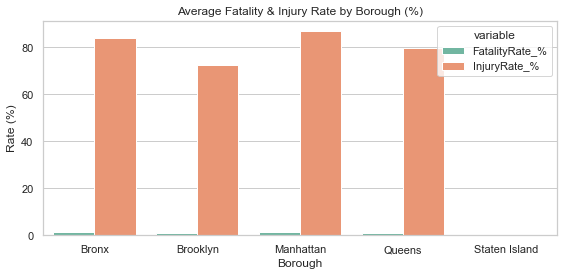


✅ Month-level fatality & injury rates:
   YearMonth  TotalFatality  TotalInjury  TotalIncident  FatalityRate_%  \
0    2024-01              0           50             57            0.00   
1    2024-02              2           42             53            3.77   
2    2024-03              0           53             59            0.00   
3    2024-04              0           51             64            0.00   
4    2024-05              0           46             62            0.00   
5    2024-06              2           55             74            2.70   
6    2024-07              1           42             54            1.85   
7    2024-08              0           43             49            0.00   
8    2024-09              0           33             41            0.00   
9    2024-10              1           33             44            2.27   
10   2024-11              0           22             37            0.00   
11   2024-12              1           33             40     

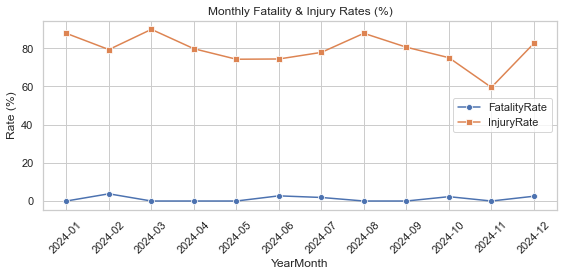


✅ Borough × Month summary:
  Borough YearMonth  TotalFatality  TotalInjury  TotalIncident  \
0   Bronx   2024-01              0            4              4   
1   Bronx   2024-02              0            2              3   
2   Bronx   2024-03              0            6              6   
3   Bronx   2024-04              0            6              7   
4   Bronx   2024-05              0            7              8   

   FatalityRate_%  InjuryRate_%  
0             0.0        100.00  
1             0.0         66.67  
2             0.0        100.00  
3             0.0         85.71  
4             0.0         87.50  


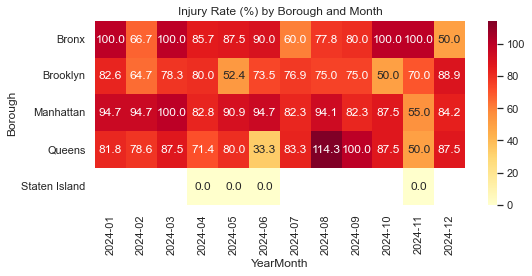

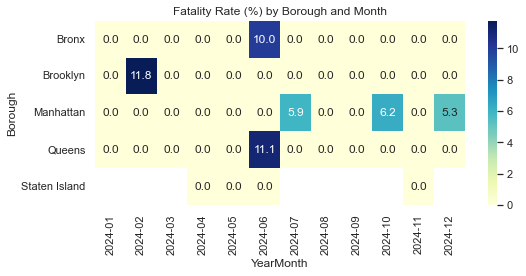

In [8]:
# %% ============================================================
# 6️⃣ Summary Statistics by Borough & Month
# 各区与各月份的死亡/受伤率分析 + 可视化 + 保存
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import os

# 创建 figures/ 目录（若不存在）
os.makedirs("figures", exist_ok=True)
os.makedirs("tables", exist_ok=True)

# ---------------------------------------------------------------
# 🧩 Step 1. 各 Borough 平均死亡率、受伤率
# ---------------------------------------------------------------

borough_summary = (
    final_df.groupby("Borough", as_index=False)
    .agg(
        AvgFatality=("Fatality", "mean"),
        AvgInjury=("Injury", "mean"),
        AvgIncident=("IncidentCount", "mean")
    )
)
borough_summary["FatalityRate_%"] = (borough_summary["AvgFatality"] / borough_summary["AvgIncident"] * 100).round(2)
borough_summary["InjuryRate_%"] = (borough_summary["AvgInjury"] / borough_summary["AvgIncident"] * 100).round(2)

print("✅ Borough-level average fatality & injury rates:")
print(borough_summary)

# 💾 保存 CSV
borough_summary.to_csv("tables/borough_summary.csv", index=False)

# Plot: 各区平均死亡率 vs 受伤率
plt.figure(figsize=(8,4))
sns.barplot(
    data=borough_summary.melt(id_vars="Borough", value_vars=["FatalityRate_%","InjuryRate_%"]),
    x="Borough", y="value", hue="variable", palette="Set2"
)
plt.title("Average Fatality & Injury Rate by Borough (%)")
plt.ylabel("Rate (%)")
plt.tight_layout()
plt.savefig("figures/borough_rate_bar.jpg", dpi=300, bbox_inches="tight")
plt.show()


# ---------------------------------------------------------------
# 🧩 Step 2. 各月份平均死亡率、受伤率
# ---------------------------------------------------------------

month_summary = (
    final_df.groupby("YearMonth", as_index=False)
    .agg(
        TotalFatality=("Fatality", "sum"),
        TotalInjury=("Injury", "sum"),
        TotalIncident=("IncidentCount", "sum")
    )
)
month_summary["FatalityRate_%"] = (month_summary["TotalFatality"] / month_summary["TotalIncident"] * 100).round(2)
month_summary["InjuryRate_%"] = (month_summary["TotalInjury"] / month_summary["TotalIncident"] * 100).round(2)

print("\n✅ Month-level fatality & injury rates:")
print(month_summary)

# 💾 保存 CSV
month_summary.to_csv("tables/month_summary.csv", index=False)

# Plot: 月度死亡率与受伤率
plt.figure(figsize=(8,4))
sns.lineplot(data=month_summary, x="YearMonth", y="FatalityRate_%", marker="o", label="FatalityRate")
sns.lineplot(data=month_summary, x="YearMonth", y="InjuryRate_%", marker="s", label="InjuryRate")
plt.title("Monthly Fatality & Injury Rates (%)")
plt.ylabel("Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("figures/month_rate_line.jpg", dpi=300, bbox_inches="tight")
plt.show()


# ---------------------------------------------------------------
# 🧩 Step 3. Borough × Month 的平均死亡/受伤百分比（二维表）
# ---------------------------------------------------------------

borough_month_summary = (
    final_df.groupby(["Borough", "YearMonth"], as_index=False)
    .agg(
        TotalFatality=("Fatality", "sum"),
        TotalInjury=("Injury", "sum"),
        TotalIncident=("IncidentCount", "sum")
    )
)
borough_month_summary["FatalityRate_%"] = (borough_month_summary["TotalFatality"] / borough_month_summary["TotalIncident"] * 100).round(2)
borough_month_summary["InjuryRate_%"] = (borough_month_summary["TotalInjury"] / borough_month_summary["TotalIncident"] * 100).round(2)

print("\n✅ Borough × Month summary:")
print(borough_month_summary.head())

# 💾 保存 CSV
borough_month_summary.to_csv("tables/borough_month_summary.csv", index=False)

# 热力图：各区各月的受伤率分布
pivot_injury = borough_month_summary.pivot(index="Borough", columns="YearMonth", values="InjuryRate_%")
plt.figure(figsize=(8,4))
sns.heatmap(pivot_injury, annot=True, cmap="YlOrRd", fmt=".1f")
plt.title("Injury Rate (%) by Borough and Month")
plt.tight_layout()
plt.savefig("figures/injury_rate_heatmap.jpg", dpi=300, bbox_inches="tight")
plt.show()

# 热力图：各区各月的死亡率分布
pivot_fatal = borough_month_summary.pivot(index="Borough", columns="YearMonth", values="FatalityRate_%")
plt.figure(figsize=(8,4))
sns.heatmap(pivot_fatal, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Fatality Rate (%) by Borough and Month")
plt.tight_layout()
plt.savefig("figures/fatality_rate_heatmap.jpg", dpi=300, bbox_inches="tight")
plt.show()


In [9]:
# 先确认 HVI 的类型和取值分布（应该大致在 1~5 或 0~1 之间，而不是很小）
print("HVI dtype:", final_df["HVI"].dtype)
print(final_df["HVI"].describe())
print(final_df["HVI"].value_counts(dropna=False).head(10))

# 若 HVI 不是数值，强制转为数值；并检查是否有大量 NaN（说明合并失败）
final_df["HVI"] = pd.to_numeric(final_df["HVI"], errors="coerce")
na_rate = final_df["HVI"].isna().mean()
print(f"⚠️ HVI NaN ratio: {na_rate:.2%}")

HVI dtype: float64
count    454.000000
mean       2.966960
std        1.394173
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: HVI, dtype: float64
2.0    124
4.0    101
5.0     84
1.0     80
3.0     65
Name: HVI, dtype: int64
⚠️ HVI NaN ratio: 0.00%


In [10]:
final_df["HVI_x_Inc"] = final_df["HVI"] * final_df["IncidentCount"]
#用事故数加权平均（Weighted Mean）
region = (
    final_df.groupby(["Borough", "YearMonth"], as_index=False)
    .agg(
        TotalIncidents=("IncidentCount", "sum"),
        Fatality=("Fatality", "sum"),
        Injury=("Injury", "sum"),
        AvgTemp=("AvgTemp", "mean"),
        AvgPrecip=("AvgPrecip", "mean"),
        HVI_sum=("HVI_x_Inc", "sum"),
    )
)
region["HVI_w"] = region["HVI_sum"] / region["TotalIncidents"]
# 保留干净原始表，防止训练过程修改掉
bm = final_df.copy()
bm = bm.merge(region[["Borough", "YearMonth", "HVI_w"]], on=["Borough", "YearMonth"], how="left")


✅ Global correlation matrix (counts only):
                       TotalIncidents  Fatality  Injury  AvgTemp  AvgPrecip  \
TotalIncidents                  1.000     0.120   0.958    0.025      0.023   
Fatality                        0.120     1.000   0.075   -0.007     -0.153   
Injury                          0.958     0.075   1.000   -0.009      0.019   
AvgTemp                         0.025    -0.007  -0.009    1.000      0.707   
AvgPrecip                       0.023    -0.153   0.019    0.707      1.000   
HVI_w                          -0.573    -0.093  -0.596   -0.000      0.005   
Borough_Brooklyn                0.485     0.045   0.347   -0.011     -0.012   
Borough_Manhattan               0.513     0.161   0.606   -0.011     -0.012   
Borough_Queens                 -0.305    -0.071  -0.287   -0.011     -0.012   
Borough_Staten Island          -0.387    -0.099  -0.417    0.067      0.074   

                       HVI_w  Borough_Brooklyn  Borough_Manhattan  \
TotalIncidents    

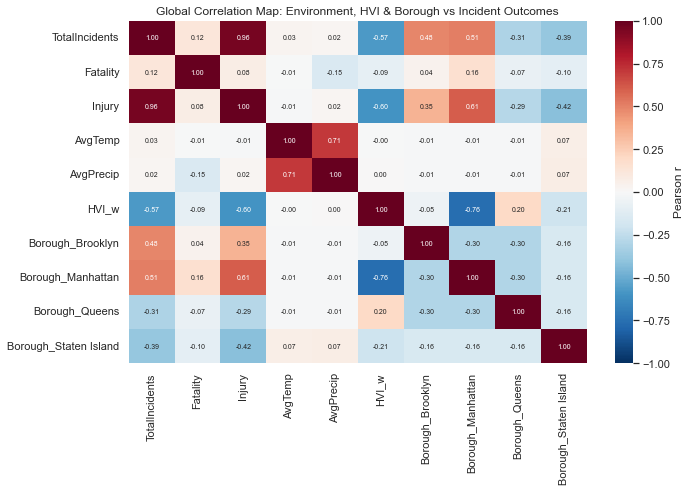

In [11]:
# %% ============================================================
# 7️⃣ Extended Correlation Heatmap (Counts Only)
# 更全面的相关性分析（不含比例变量）
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# 创建保存目录
os.makedirs("figures", exist_ok=True)
os.makedirs("tables", exist_ok=True)

# ---------- Step 1. 把 Borough 转成数值（dummy variable） ----------
borough_dummies = pd.get_dummies(region["Borough"], prefix="Borough", drop_first=True)
region_num = pd.concat([region, borough_dummies], axis=1)

# ---------- Step 2. 构造可分析字段 ----------
corr_vars = [
    "TotalIncidents", "Fatality", "Injury",     # 因变量（事故结果）
    "AvgTemp", "AvgPrecip", "HVI_w",           # 自变量（环境因素）
] + list(borough_dummies.columns)               # 各区的 one-hot 数值变量

# ---------- Step 3. 检查并计算相关矩阵 ----------
corr_vars = [c for c in corr_vars if c in region_num.columns]  # 防止列缺失
corr_full = region_num[corr_vars].corr()

# 💾 保存相关矩阵为 CSV
corr_full.round(3).to_csv("tables/global_correlation_matrix.csv")

print("✅ Global correlation matrix (counts only):")
print(corr_full.round(3))

# ---------- Step 4. 绘制全局热力图 ----------
plt.figure(figsize=(10, 7))
sns.heatmap(
    corr_full, annot=True, cmap="RdBu_r", vmin=-1, vmax=1, fmt=".2f",
    cbar_kws={'label': 'Pearson r'}, annot_kws={"size": 7}
)
plt.title("Global Correlation Map: Environment, HVI & Borough vs Incident Outcomes", fontsize=12)
plt.tight_layout()

# 💾 保存图像
plt.savefig("figures/global_correlation_heatmap.jpg", dpi=300, bbox_inches="tight")
plt.show()


✅ Log-scaled correlation matrix:
                    AvgTemp  AvgPrecip  HVI_w  log_TotalIncidents  \
AvgTemp               1.000      0.707 -0.000               0.016   
AvgPrecip             0.707      1.000  0.005               0.003   
HVI_w                -0.000      0.005  1.000              -0.468   
log_TotalIncidents    0.016      0.003 -0.468               1.000   
log_Fatality          0.023     -0.107 -0.104               0.185   
log_Injury           -0.019     -0.006 -0.369               0.955   

                    log_Fatality  log_Injury  
AvgTemp                    0.023      -0.019  
AvgPrecip                 -0.107      -0.006  
HVI_w                     -0.104      -0.369  
log_TotalIncidents         0.185       0.955  
log_Fatality               1.000       0.133  
log_Injury                 0.133       1.000  


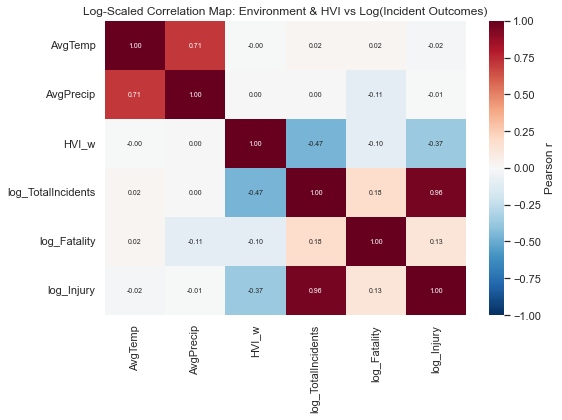

In [12]:
# %% ============================================================
# 8️⃣ Log-Scaled Correlation Heatmap (for Modeling Preparation)
# 基于对数转换的相关性热图（建模前检验） # 避免 log(0) 报错
# ============================================================

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 创建保存目录
os.makedirs("figures", exist_ok=True)
os.makedirs("tables", exist_ok=True)

# Step 1️⃣: 选取要 log-transform 的计数变量（避免 0 报错）
log_cols = ["TotalIncidents", "Fatality", "Injury"]
for col in log_cols:
    region_num[f"log_{col}"] = np.log1p(region_num[col])   # log(1+x)

# Step 2️⃣: 构造 log 版本分析列
log_corr_vars = [
    "AvgTemp", "AvgPrecip", "HVI_w"  # 自变量
] + [f"log_{c}" for c in log_cols]   # 对数后的因变量

# Step 3️⃣: 检查并计算 log 相关矩阵
log_corr_vars = [c for c in log_corr_vars if c in region_num.columns]
corr_log = region_num[log_corr_vars].corr()

# 💾 保存 CSV
corr_log.round(3).to_csv("tables/log_scaled_correlation_matrix.csv")

print("✅ Log-scaled correlation matrix:")
print(corr_log.round(3))

# Step 4️⃣: 绘制 log color map
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_log, annot=True, cmap="RdBu_r",
    vmin=-1, vmax=1, fmt=".2f",
    cbar_kws={'label': 'Pearson r'},
    annot_kws={"size": 7}
)
plt.title("Log-Scaled Correlation Map: Environment & HVI vs Log(Incident Outcomes)", fontsize=12)
plt.tight_layout()

# 💾 保存图像
plt.savefig("figures/log_scaled_correlation_heatmap.jpg", dpi=300, bbox_inches="tight")
plt.show()



📈 Poisson Model: Injury Count (Borough × Month)
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Injury   No. Observations:                   52
Model:                            GLM   Df Residuals:                       44
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -102.41
Date:                Tue, 21 Oct 2025   Deviance:                       13.400
Time:                        17:16:39   Pearson chi2:                     12.4
No. Iterations:                    23   Pseudo R-squ. (CS):             0.2261
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

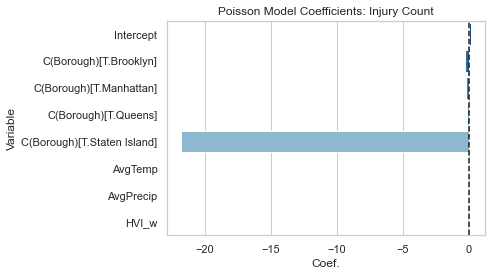


💀 Negative Binomial Model: Fatality Count (Borough × Month)
                 Generalized Linear Model Regression Results                  
Dep. Variable:               Fatality   No. Observations:                   52
Model:                            GLM   Df Residuals:                       44
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18.420
Date:                Tue, 21 Oct 2025   Deviance:                       19.158
Time:                        17:16:40   Pearson chi2:                     32.5
No. Iterations:                    19   Pseudo R-squ. (CS):            0.07004
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

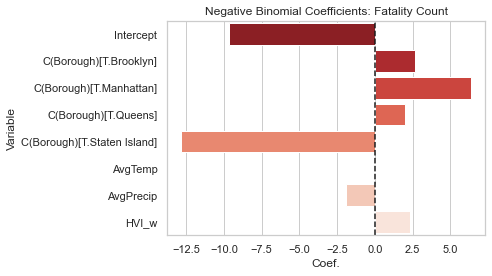

In [13]:
# %% ============================================================
# 7️⃣ Statistical Modeling (Borough × Month Level)
# Poisson / Negative Binomial 回归模型
# ============================================================

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 创建保存目录
os.makedirs("figures", exist_ok=True)
os.makedirs("tables", exist_ok=True)

# ---------------------------------------------------------------
# 🧩 数据准备
# ---------------------------------------------------------------
bm = region.copy()
bm["logExp"] = np.log(bm["TotalIncidents"].clip(lower=1))  # offset term

# ---------------------------------------------------------------
# 1️⃣ Poisson 模型（预测 Injury 数）
# ---------------------------------------------------------------
m1 = smf.glm(
    formula="Injury ~ AvgTemp + AvgPrecip + HVI_w + C(Borough)",
    data=bm,
    family=sm.families.Poisson(),
    offset=bm["logExp"]
).fit()

print("\n📈 Poisson Model: Injury Count (Borough × Month)")
print(m1.summary())

# 提取回归结果为 DataFrame
m1_df = m1.summary2().tables[1].reset_index()
m1_df.rename(columns={"index": "Variable"}, inplace=True)

# 💾 保存为 CSV
m1_df.to_csv("tables/poisson_injury_model.csv", index=False)

# 绘图：Poisson 系数条形图
plt.figure(figsize=(7,4))
sns.barplot(data=m1_df, x="Coef.", y="Variable", palette="Blues_r")
plt.axvline(0, color='k', linestyle='--')
plt.title("Poisson Model Coefficients: Injury Count")
plt.tight_layout()
plt.savefig("figures/poisson_injury_coefficients.jpg", dpi=300, bbox_inches="tight")
plt.show()


# ---------------------------------------------------------------
# 2️⃣ Negative Binomial 模型（预测 Fatality 数）
# ---------------------------------------------------------------
m2 = smf.glm(
    formula="Fatality ~ AvgTemp + AvgPrecip + HVI_w + C(Borough)",
    data=bm,
    family=sm.families.NegativeBinomial(),
    offset=bm["logExp"]
).fit()

print("\n💀 Negative Binomial Model: Fatality Count (Borough × Month)")
print(m2.summary())

# 提取回归结果为 DataFrame
m2_df = m2.summary2().tables[1].reset_index()
m2_df.rename(columns={"index": "Variable"}, inplace=True)

# 💾 保存为 CSV
m2_df.to_csv("tables/neg_bin_fatality_model.csv", index=False)

# 绘图：Negative Binomial 系数条形图
plt.figure(figsize=(7,4))
sns.barplot(data=m2_df, x="Coef.", y="Variable", palette="Reds_r")
plt.axvline(0, color='k', linestyle='--')
plt.title("Negative Binomial Coefficients: Fatality Count")
plt.tight_layout()
plt.savefig("figures/neg_bin_fatality_coefficients.jpg", dpi=300, bbox_inches="tight")
plt.show()


In [14]:
final_df
# 从 YearMonth 提取月份
final_df["Month"] = final_df["YearMonth"].str.split("-").str[1].astype(int)
print(final_df[["YearMonth", "Month"]].head())
# 保留干净原始表，防止训练过程修改掉
bm["Month"] = bm["YearMonth"].str.split("-").str[1].astype(int)
print(bm[["YearMonth", "Month"]].head())



  YearMonth  Month
0   2024-02      2
1   2024-03      3
2   2024-04      4
3   2024-06      6
4   2024-07      7
  YearMonth  Month
0   2024-01      1
1   2024-02      2
2   2024-03      3
3   2024-04      4
4   2024-05      5


## 7️⃣ Statistical Modeling (Borough × Month Level)
**Poisson / Negative Binomial 回归模型**

Poisson 模型：
$$
Y_i \sim \text{Poisson}(\mu_i), \quad
\log(\mu_i) = \beta_0 + \beta_1 \text{AvgTemp}_i + 
\beta_2 \text{HVI}_i + 
\sum_k \gamma_k I(\text{Borough}_i=k) + 
\log(\text{Exposure}_i)
$$

Negative Binomial 模型：
$$
Y_i \sim \text{NegBin}(\mu_i, \alpha), \quad
\log(\mu_i) = \beta_0 + \beta_1 \text{AvgTemp}_i + 
\beta_2 \text{HVI}_i + 
\sum_k \gamma_k I(\text{Borough}_i=k) + 
\log(\text{Exposure}_i)
$$

$$
\mathrm{Var}(Y_i) = \mu_i + \alpha \mu_i^2
$$

*References:*  
Hilbe (2011), *Negative Binomial Regression*.  
Cameron & Trivedi (2013), *Regression Analysis of Count Data*.


✅ 所需列完整，可建模。
✅ Modeling dataset shape: (52, 7)
⚠️ Perfect separation detected in Injury — 尝试简化模型（去掉 Month）...
⚠️ 仍然分离，进一步简化（去掉 Borough）...
✅ 成功拟合最简 Injury 模型：HasInjury ~ AvgTemp + AvgPrecip + HVI_w
✅ 成功拟合 Fatality 模型：HasFatal ~ AvgTemp + AvgPrecip + HVI_w + C(Borough) + C(Month)

🩹 Logistic Model: Probability of Injury per Incident
                           Logit Regression Results                           
Dep. Variable:              HasInjury   No. Observations:                   52
Model:                          Logit   Df Residuals:                       48
Method:                           MLE   Df Model:                            3
Date:                Tue, 21 Oct 2025   Pseudo R-squ.:                 0.09306
Time:                        17:16:40   Log-Likelihood:                -12.790
converged:                       True   LL-Null:                       -14.102
Covariance Type:            nonrobust   LLR p-value:                    0.4532
                 coef    std err  

E:\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


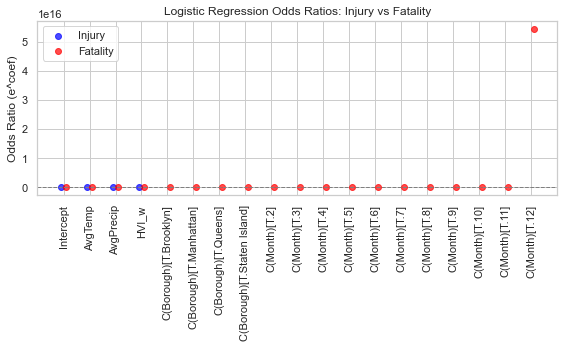

🖼️ 已保存图形至: figures\logit_injury_fatality_OR.png


In [15]:
# %% ============================================================
# 9️⃣ Logistic Modeling (Event Level)
# 自动处理 Perfect Separation + 保存表格 & 图形（基于 bm1）
# ============================================================

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import PerfectSeparationError
import matplotlib.pyplot as plt
import os

# 💾 复制建模副本，避免修改原始数据
bm1 = bm.copy()

# ---------- Step 1️⃣: 构造二元因变量 ----------
bm1["HasInjury"] = (bm1["Injury"] > 0).astype(int)
bm1["HasFatal"]  = (bm1["Fatality"] > 0).astype(int)

# ---------- Step 2️⃣: 检查输入变量 ----------
model_vars = ["HasInjury", "HasFatal", "AvgTemp", "AvgPrecip", "HVI_w", "Borough", "Month"]
missing = [c for c in model_vars if c not in bm1.columns]
if missing:
    raise ValueError(f"⚠️ 缺少列: {missing}")
else:
    print("✅ 所需列完整，可建模。")

# 删除缺失行
df_logit = bm1[model_vars].dropna().copy()
print(f"✅ Modeling dataset shape: {df_logit.shape}")

# ---------- Step 3️⃣: 定义通用建模函数 ----------
def safe_logit(formula, data, label):
    """
    自动处理 PerfectSeparationError 的逻辑回归
    """
    try:
        model = smf.logit(formula=formula, data=data).fit(disp=False)
        print(f"✅ 成功拟合 {label} 模型：{formula}")
        return model
    except PerfectSeparationError:
        print(f"⚠️ Perfect separation detected in {label} — 尝试简化模型（去掉 Month）...")
        try:
            simple_formula = formula.replace("+ C(Month)", "")
            model = smf.logit(formula=simple_formula, data=data).fit(disp=False)
            print(f"✅ 成功拟合简化 {label} 模型：{simple_formula}")
            return model
        except PerfectSeparationError:
            print(f"⚠️ 仍然分离，进一步简化（去掉 Borough）...")
            minimal_formula = "HasInjury ~ AvgTemp + AvgPrecip + HVI_w" if "Injury" in label \
                              else "HasFatal ~ AvgTemp + AvgPrecip + HVI_w"
            model = smf.logit(formula=minimal_formula, data=data).fit(disp=False)
            print(f"✅ 成功拟合最简 {label} 模型：{minimal_formula}")
            return model

# ---------- Step 4️⃣: 建立两个模型 ----------
formula_inj = "HasInjury ~ AvgTemp + AvgPrecip + HVI_w + C(Borough) + C(Month)"
formula_fat = "HasFatal ~ AvgTemp + AvgPrecip + HVI_w + C(Borough) + C(Month)"

logit_inj = safe_logit(formula_inj, df_logit, label="Injury")
logit_fat = safe_logit(formula_fat, df_logit, label="Fatality")

# ---------- Step 5️⃣: 输出结果 ----------
print("\n🩹 Logistic Model: Probability of Injury per Incident")
print(logit_inj.summary())

print("\n⚰️ Logistic Model: Probability of Fatality per Incident")
print(logit_fat.summary())

# ---------- Step 6️⃣: 计算并保存优势比 ----------
odds_inj = np.exp(logit_inj.params).rename("OddsRatio_Injury")
odds_fat = np.exp(logit_fat.params).rename("OddsRatio_Fatality")

odds_df = pd.concat([odds_inj, odds_fat], axis=1).round(3)

# 保存表格
os.makedirs("figures", exist_ok=True)
table_path = os.path.join("figures", "logit_odds_summary.csv")
odds_df.to_csv(table_path)
print(f"📄 已保存优势比表格至: {table_path}")

# ---------- Step 7️⃣: 绘制并保存图形 ----------
plt.figure(figsize=(8, 5))
x = np.arange(len(odds_df))
plt.scatter(x - 0.1, odds_df["OddsRatio_Injury"], color="blue", label="Injury", alpha=0.7)
plt.scatter(x + 0.1, odds_df["OddsRatio_Fatality"], color="red", label="Fatality", alpha=0.7)
plt.axhline(1, color="gray", linestyle="--", linewidth=1)
plt.xticks(x, odds_df.index, rotation=90)
plt.ylabel("Odds Ratio (e^coef)")
plt.title("Logistic Regression Odds Ratios: Injury vs Fatality")
plt.legend()
plt.tight_layout()

fig_path = os.path.join("figures", "logit_injury_fatality_OR.png")
plt.savefig(fig_path, dpi=300)
plt.show()
print(f"🖼️ 已保存图形至: {fig_path}")


The logistic regression model is:

$$
Y_i \sim \text{Bernoulli}(p_i), \quad 
\log\!\left(\frac{p_i}{1 - p_i}\right)
= \beta_0 + \beta_1 \text{AvgTemp}_i +
\beta_2 \text{HVI}_i +
\sum_k \gamma_k I(\text{Borough}_i = k) +
\sum_m \delta_m I(\text{Month}_i = m)
$$

where  
\( p_i = P(Y_i = 1 \mid X_i) \) is the probability of injury or fatality per incident,  
\( \beta, \gamma, \delta \) are regression coefficients estimated via Maximum Likelihood,  
\( \text{AvgTemp}, \text{HVI} \) are continuous predictors,  
\( C(\text{Borough}), C(\text{Month}) \) are categorical dummies.  

**References:**  
Hosmer, D. W., Lemeshow, S., & Sturdivant, R. X. (2013). *Applied Logistic Regression* (3rd ed.). Wiley.  
Cameron, A. C., & Trivedi, P. K. (2013). *Regression Analysis of Count Data* (2nd ed.). Cambridge University Press.


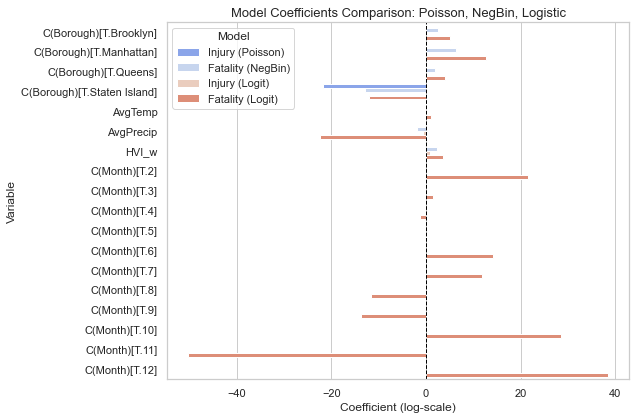

✅ Combined Model Coefficients:
Model                        Fatality (Logit)  Fatality (NegBin)  \
Variable                                                           
AvgPrecip                             -22.368             -1.893   
AvgTemp                                 1.034              0.039   
C(Borough)[T.Brooklyn]                  5.153              2.662   
C(Borough)[T.Manhattan]                12.650              6.348   
C(Borough)[T.Queens]                    4.082              2.010   
C(Borough)[T.Staten Island]           -11.944            -12.819   
C(Month)[T.10]                         28.470                NaN   
C(Month)[T.11]                        -50.291                NaN   
C(Month)[T.12]                         38.536                NaN   
C(Month)[T.2]                          21.535                NaN   
C(Month)[T.3]                           1.565                NaN   
C(Month)[T.4]                          -1.263                NaN   
C(Month)[T.5]    

In [16]:
# %% ============================================================
# 🔟 Visualization 1 — Coefficient Plot
# Poisson / NegBin / Logistic 模型系数可视化对比
# ============================================================

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---------- Step 0️⃣: 确保输出文件夹存在 ----------
os.makedirs("tables", exist_ok=True)
os.makedirs("figures", exist_ok=True)

# ---------- Step 1️⃣: 提取各模型参数 ----------
# Poisson
coef_df1 = m1.params.to_frame("coef").reset_index().rename(columns={"index": "Variable"})
coef_df1["Model"] = "Injury (Poisson)"

# NegBin
coef_df2 = m2.params.to_frame("coef").reset_index().rename(columns={"index": "Variable"})
coef_df2["Model"] = "Fatality (NegBin)"

# Logistic: Injury
coef_df3 = logit_inj.params.to_frame("coef").reset_index().rename(columns={"index": "Variable"})
coef_df3["Model"] = "Injury (Logit)"

# Logistic: Fatality
coef_df4 = logit_fat.params.to_frame("coef").reset_index().rename(columns={"index": "Variable"})
coef_df4["Model"] = "Fatality (Logit)"

# ---------- Step 2️⃣: 合并所有模型 ----------
coef_all = pd.concat([coef_df1, coef_df2, coef_df3, coef_df4], ignore_index=True)

# ---------- Step 3️⃣: 去除截距项 Intercept ----------
coef_all = coef_all[~coef_all["Variable"].str.contains("Intercept", case=False)]

# ---------- Step 4️⃣: 绘图 ----------
plt.figure(figsize=(9, 6))
sns.barplot(
    data=coef_all,
    x="coef", y="Variable", hue="Model",
    palette="coolwarm", orient="h"
)
plt.axvline(0, color="black", linestyle="--", lw=1)
plt.title("Model Coefficients Comparison: Poisson, NegBin, Logistic", fontsize=13)
plt.xlabel("Coefficient (log-scale)")
plt.ylabel("Variable")
plt.tight_layout()

# 保存图像（任选格式）
fig_path_png = "figures/coef_comparison.png"
fig_path_jpg = "figures/coef_comparison.jpg"
plt.savefig(fig_path_png, dpi=300, bbox_inches="tight")
plt.savefig(fig_path_jpg, dpi=300, bbox_inches="tight")
plt.show()

# ---------- Step 5️⃣: 导出汇总表 ----------
coef_summary = coef_all.pivot_table(index="Variable", columns="Model", values="coef")
coef_summary_rounded = coef_summary.round(3)

# 保存为 CSV
table_path = "tables/coef_summary.csv"
coef_summary_rounded.to_csv(table_path, index=True)

# 显示结果
print("✅ Combined Model Coefficients:")
print(coef_summary_rounded)
print(f"\n✅ Table saved to {table_path}")
print(f"✅ Figures saved to {fig_path_png} and {fig_path_jpg}")


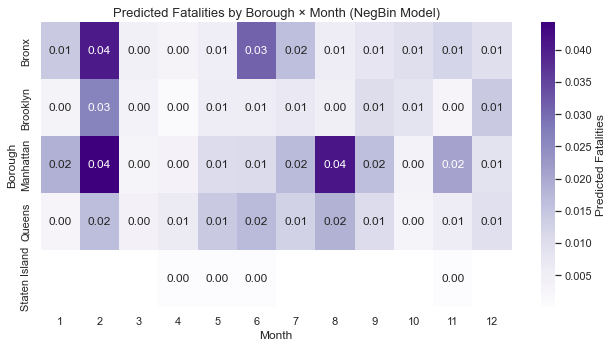

✅ Predicted Fatalities heatmap and table saved successfully!
📊 Table saved to: tables/pred_fatal_heatmap.csv
🖼️ Figures saved to: figures/pred_fatal_heatmap.png and figures/pred_fatal_heatmap.jpg


In [17]:
# %% ============================================================
# Visualization 1 — Predicted Fatalities by Borough × Month
# ============================================================

import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ---------- Step 0️⃣: 确保输出文件夹存在 ----------
os.makedirs("tables", exist_ok=True)
os.makedirs("figures", exist_ok=True)

# ---------- Step 1️⃣: 使用 NegBin 模型预测 ----------
bm["PredFatal_NB"] = m2.predict(bm)

# ---------- Step 2️⃣: 构建 Borough × Month 透视表 ----------
pivot_fatal = (
    bm.groupby(["Borough", "Month"], as_index=False)["PredFatal_NB"]
      .mean()
      .pivot(index="Borough", columns="Month", values="PredFatal_NB")
)

# ---------- Step 3️⃣: 绘制热力图 ----------
plt.figure(figsize=(9, 5))
sns.heatmap(
    pivot_fatal,
    annot=True, fmt=".2f", cmap="Purples",
    cbar_kws={"label": "Predicted Fatalities"}
)
plt.title("Predicted Fatalities by Borough × Month (NegBin Model)", fontsize=13)
plt.xlabel("Month")
plt.ylabel("Borough")
plt.tight_layout()

# ---------- Step 4️⃣: 保存图像 ----------
fig_path_png = "figures/pred_fatal_heatmap.png"
fig_path_jpg = "figures/pred_fatal_heatmap.jpg"
plt.savefig(fig_path_png, dpi=300, bbox_inches="tight")
plt.savefig(fig_path_jpg, dpi=300, bbox_inches="tight")
plt.show()

# ---------- Step 5️⃣: 保存表格 ----------
table_path = "tables/pred_fatal_heatmap.csv"
pivot_fatal.round(2).to_csv(table_path)

# ---------- Step 6️⃣: 输出提示 ----------
print("✅ Predicted Fatalities heatmap and table saved successfully!")
print(f"📊 Table saved to: {table_path}")
print(f"🖼️ Figures saved to: {fig_path_png} and {fig_path_jpg}")


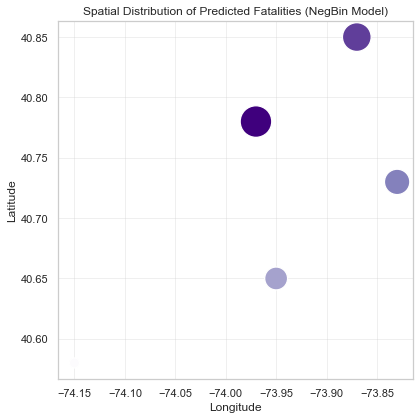

✅ Spatial distribution figure and table saved successfully!
📊 Table saved to: tables/pred_fatal_spatial.csv
🖼️ Figures saved to: figures/pred_fatal_spatial.png and figures/pred_fatal_spatial.jpg


In [18]:
# %% ============================================================
# Visualization 4 — Spatial Distribution by Borough
# ============================================================

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---------- Step 0️⃣: 确保输出文件夹存在 ----------
os.makedirs("tables", exist_ok=True)
os.makedirs("figures", exist_ok=True)

# ---------- Step 1️⃣: 定义 Borough 坐标 ----------
borough_coords = pd.DataFrame({
    "Borough": ["Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island"],
    "Lat": [40.85, 40.65, 40.78, 40.73, 40.58],
    "Lon": [-73.87, -73.95, -73.97, -73.83, -74.15]
})

# ---------- Step 2️⃣: 合并预测结果 ----------
map_df = (
    bm.groupby("Borough", as_index=False)["PredFatal_NB"]
      .mean()
      .merge(borough_coords, on="Borough")
)

# ---------- Step 3️⃣: 绘制空间分布散点图 ----------
plt.figure(figsize=(6, 6))
sns.scatterplot(
    data=map_df,
    x="Lon", y="Lat",
    size="PredFatal_NB", hue="PredFatal_NB",
    sizes=(100, 1000),
    palette="Purples",
    legend=False
)
plt.title("Spatial Distribution of Predicted Fatalities (NegBin Model)", fontsize=12)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(alpha=0.3)
plt.tight_layout()

# ---------- Step 4️⃣: 保存图像 ----------
fig_path_png = "figures/pred_fatal_spatial.png"
fig_path_jpg = "figures/pred_fatal_spatial.jpg"
plt.savefig(fig_path_png, dpi=300, bbox_inches="tight")
plt.savefig(fig_path_jpg, dpi=300, bbox_inches="tight")
plt.show()

# ---------- Step 5️⃣: 保存表格 ----------
table_path = "tables/pred_fatal_spatial.csv"
map_df.round(3).to_csv(table_path, index=False)

# ---------- Step 6️⃣: 输出提示 ----------
print("✅ Spatial distribution figure and table saved successfully!")
print(f"📊 Table saved to: {table_path}")
print(f"🖼️ Figures saved to: {fig_path_png} and {fig_path_jpg}")
